(sarima_catfish)=
# SARIMA: Catfish Sales Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0).squeeze("columns")

In [4]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [5]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

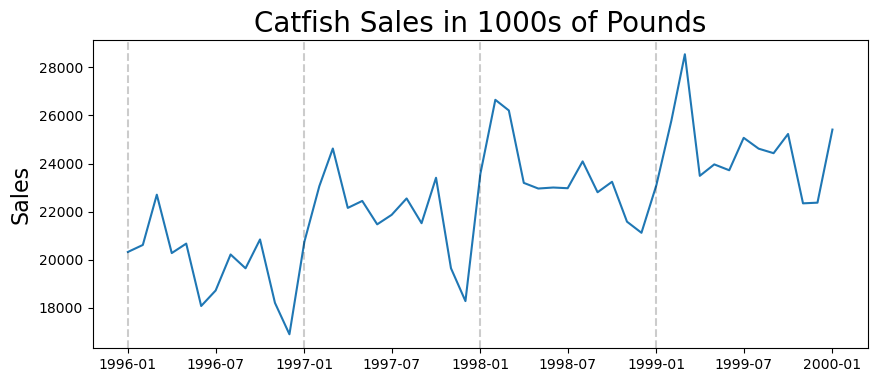

In [6]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [7]:
first_diff = lim_catfish_sales.diff()[1:]

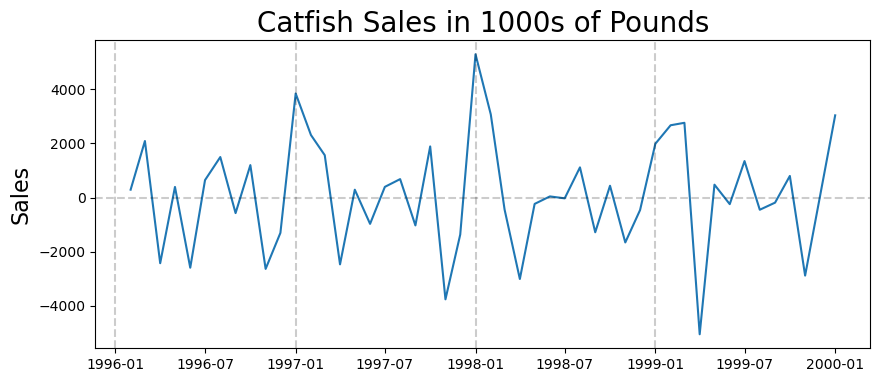

In [8]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

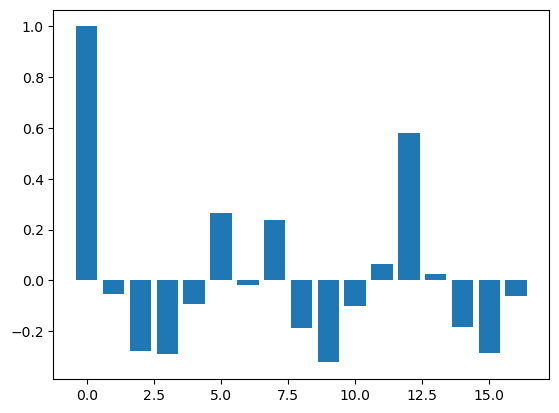

In [9]:
acf_vals = acf(first_diff)
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags]);

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

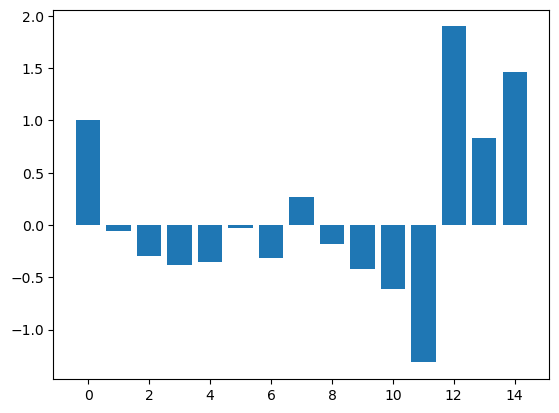

In [10]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [11]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# Fit the SARIMA Model

In [12]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [13]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91418D+00    |proj g|=  1.42265D+00

At iterate    5    f=  8.54683D+00    |proj g|=  2.47769D-01

At iterate   10    f=  8.53059D+00    |proj g|=  1.21746D-03

At iterate   15    f=  8.53059D+00    |proj g|=  1.23643D-03

At iterate   20    f=  8.53051D+00    |proj g|=  1.57533D-02

At iterate   25    f=  8.52658D+00    |proj g|=  7.30506D-02

At iterate   30    f=  8.51412D+00    |proj g|=  2.67419D-02

At iterate   35    f=  8.50324D+00    |proj g|=  8.46847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


In [14]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Thu, 04 Apr 2024   AIC                            737.269
Time:                                      08:26:09   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.847      0.000       0.589       1.061
ma.S.L12      -0.51

In [15]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

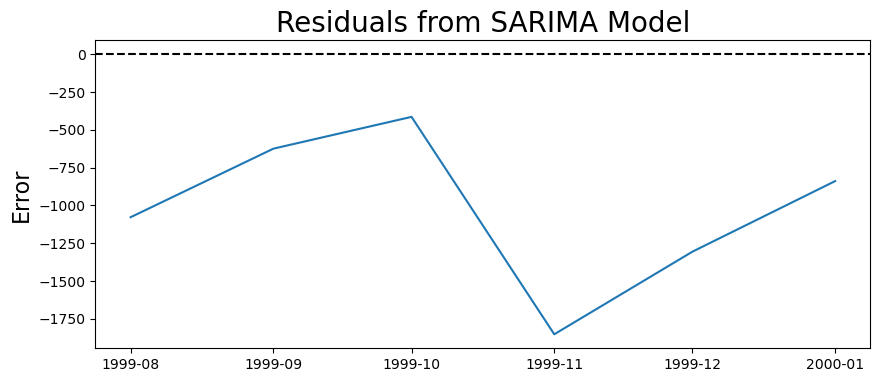

In [16]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

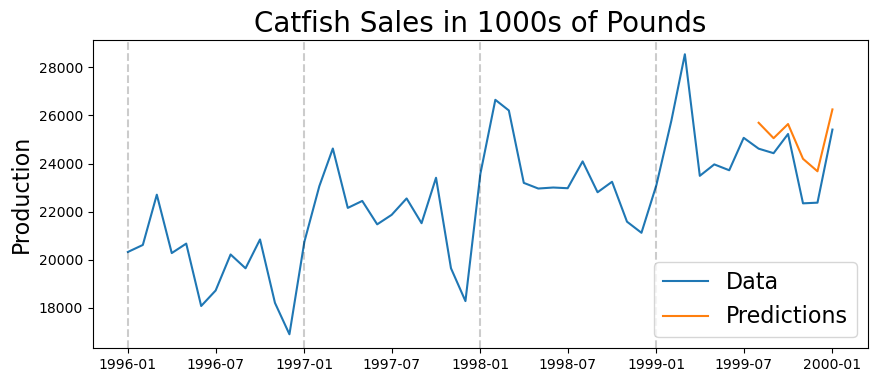

In [17]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [18]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [19]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.3018259717915


# Using the Rolling Forecast Origin

In [20]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91418D+00    |proj g|=  1.42265D+00

At iterate    5    f=  8.54683D+00    |proj g|=  2.47769D-01

At iterate   10    f=  8.53059D+00    |proj g|=  1.21746D-03

At iterate   15    f=  8.53059D+00    |proj g|=  1.23643D-03

At iterate   20    f=  8.53051D+00    |proj g|=  1.57533D-02

At iterate   25    f=  8.52658D+00    |proj g|=  7.30506D-02

At iterate   30    f=  8.51412D+00    |proj g|=  2.67419D-02

At iterate   35    f=  8.50324D+00    |proj g|=  8.46847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/var/folders/h3/5svt7fds58v0x7kkc54kl3640000gn/T/ipykernel_15165/3978322752.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25695.47055246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py


At iterate   40    f=  8.50171D+00    |proj g|=  3.32685D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     49      1     0     0   9.110D-06   8.502D+00
  F =   8.5017078631245955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89744D+00    |proj g|=  1.39659D+00

At iterate    5    f=  8.53679D+00    |proj g|=  2.33465D-01

At iterate   10    f=  8.52165D+00    |proj g|=  1.07445D-03

At iter

/var/folders/h3/5svt7fds58v0x7kkc54kl3640000gn/T/ipykernel_15165/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/var/folders/h3/5svt7fds58v0x7kkc54kl3640000gn/T/ipykernel_15165/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fu


At iterate   10    f=  8.51407D+00    |proj g|=  1.40560D-03

At iterate   15    f=  8.51407D+00    |proj g|=  7.98632D-04

At iterate   20    f=  8.51401D+00    |proj g|=  1.54164D-02

At iterate   25    f=  8.50610D+00    |proj g|=  7.44241D-02

At iterate   30    f=  8.49666D+00    |proj g|=  2.70361D-02

At iterate   35    f=  8.49013D+00    |proj g|=  7.29900D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     48      1     0     0   7.069D-06   8.490D+00
  F =   8.4898467456765800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/var/folders/h3/5svt7fds58v0x7kkc54kl3640000gn/T/ipykernel_15165/3978322752.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/phil/mini310/envs/arima/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/h3/5svt7fds58v0x7kkc54kl3640000gn/T/ipykernel_15165/3978322752.py:8:

In [21]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

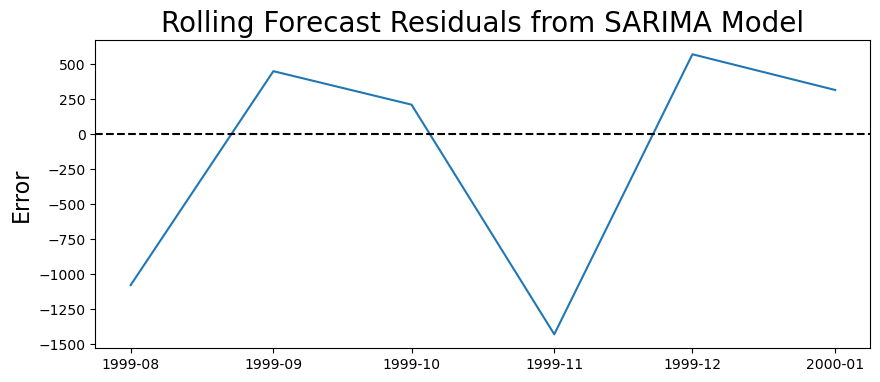

In [22]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

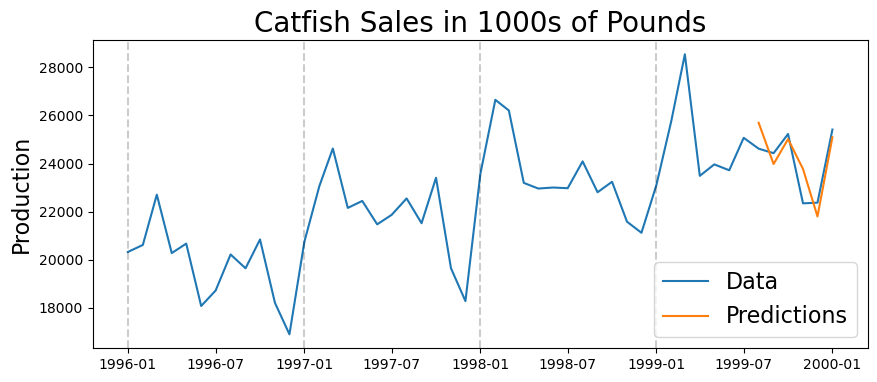

In [23]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [24]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0288


In [25]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 804.124026465311
